In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
import os
from sklearn import preprocessing
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import imshow

In [360]:
folders = ['./data/Person', './data/Sport']
final_size = (8,8)
count = 0
enco_bat_size = 100
fol_counts = [0,0]

for i in range(2):
    fdirs = os.listdir(folders[i])
    fol_counts[i] += len(fdirs)

original_data_person = np.zeros(shape=(fol_counts[0],final_size[0]*final_size[1]))
original_data_sport = np.zeros(shape=(fol_counts[1],final_size[0]*final_size[1]))


In [361]:
def get_image_data(path):
    img = Image.open(path)
    arr = np.array(img.resize(final_size).convert('L')).flatten()
    img.close()
    return arr
names_person = []
names_sport = []

def get_fol_data(fol,data,names):
    image = 0
    fdirs = os.listdir(fol)
    for fil in fdirs:
        path = fol + "/" + fil
        data[image] = get_image_data(path)
        image = image+1
        if image%500 == 0:
            print(fol," ",image)
        names.append(fil)
    return data

original_data_person = get_fol_data(folders[0],original_data_person,names_person)
original_data_sport = get_fol_data(folders[1],original_data_sport,names_sport)  

('./data/Person', ' ', 500)
('./data/Person', ' ', 1000)
('./data/Sport', ' ', 500)
('./data/Sport', ' ', 1000)
('./data/Sport', ' ', 1500)


In [362]:
print(original_data_person.shape,original_data_sport.shape)

((1242, 64), (1888, 64))


In [363]:
std_scale = preprocessing.StandardScaler().fit(original_data_person)
scaled_original_data_person = std_scale.transform(original_data_person)

std_scale = preprocessing.StandardScaler().fit(original_data_sport)
scaled_original_data_sport = std_scale.transform(original_data_sport)

In [364]:
def sigmoid(x):
    return 1. / 1. + np.exp(-x)

In [370]:
boundary_person = int(0.8*scaled_original_data_person.shape[0])
boundary_sport = int(0.8*scaled_original_data_sport.shape[0])

training_data_person = scaled_original_data_person[0:boundary_person,:]
testing_data_person = scaled_original_data_person[boundary_person:,:]

training_data_sport = scaled_original_data_sport[0:boundary_sport,:]
testing_data_sport = scaled_original_data_sport[boundary_sport:,:]

training_data_person = training_data_person[:100]
training_data_sport = training_data_sport[:100]
testing_data_person = testing_data_person[:100]
testing_data_sport = testing_data_sport[:100]


combined_training = np.vstack((training_data_person,training_data_sport))
combined_testing = np.vstack((testing_data_person,testing_data_sport))

print testing_data_person.shape,training_data_person.shape
print testing_data_sport.shape,training_data_sport.shape

(100, 64) (100, 64)
(100, 64) (100, 64)


In [389]:
def auto_encoder(training_data,number_iterations,learning_rate, errors, layers, sparsity_level, sparse=False):
    top_k_layers = [int(sparsity_level * a) for a in layers]
    sess = tf.Session()
    start = 0
    end = start + enco_bat_size
    original_data_dim = training_data.shape[1]
    with sess.as_default():
        hidden_dim = layers[0]
        input_dim = original_data_dim
        x = tf.placeholder("float", [None, input_dim])
        W1 = tf.Variable(tf.random_uniform([input_dim, hidden_dim], -1.0 / math.sqrt(input_dim),\
                                          1.0 / math.sqrt(input_dim)))
        b1 = tf.Variable(tf.zeros([hidden_dim]))
        z1 = tf.nn.tanh(tf.matmul(x,W1) + b1)
        
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[0])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[enco_bat_size,1])
            z_new = tf.sub(z1,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z1
        
        input_dim = hidden_dim
        hidden_dim = layers[1]
        W2 = tf.Variable(tf.random_uniform([input_dim, hidden_dim], -1.0 / math.sqrt(input_dim),\
                                          1.0 / math.sqrt(input_dim)))
        b2 = tf.Variable(tf.zeros([hidden_dim]))
        z2 = tf.nn.tanh(tf.matmul(z1,W2) + b2)
        
        if sparse:
            vals,indices = tf.nn.top_k(z2,top_k_layers[1])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[enco_bat_size,1])
            z_new = tf.sub(z2,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z2
        
        Wdash2 = tf.transpose(W2)
        bdash2 = tf.Variable(tf.zeros([layers[0]]))
        reconstructed_x1 = tf.nn.tanh(tf.matmul(z_new,Wdash2) + bdash2)
        
        
        Wdash1 = tf.transpose(W1)
        bdash1 = tf.Variable(tf.zeros([original_data_dim]))
        reconstructed_x = tf.nn.tanh(tf.matmul(reconstructed_x1,Wdash1) + bdash1)
        

        error = tf.reduce_mean(tf.square(x-reconstructed_x))
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(error)
        init = tf.initialize_all_variables()
        sess.run(init)

        for i in range(number_iterations): 
            batch_rows = np.random.choice(range(0,training_data.shape[0]), enco_bat_size, replace=False)
            batch = training_data[batch_rows][:]
            sess.run(train_step, feed_dict={x: batch})
            e = sess.run(error, feed_dict={x: batch})
            errors.append(e)
            if i % 100 == 0:
                print "Done",i
            
        print "Autoencoder training done"
        w1_final = sess.run(W1)
        b1_final = sess.run(b1)
        w2_final = sess.run(W2)
        b2_final = sess.run(b2)
        w1_dash_final = sess.run(Wdash1)
        b1_dash_final = sess.run(bdash1)
        w2_dash_final = sess.run(Wdash2)
        b2_dash_final = sess.run(bdash2)
        ws = [w1_final,w2_final]
        ws_dash = [w1_dash_final,w2_dash_final]
        bs = [b1_final, b2_final]
        bs_dash = [b1_dash_final,b2_dash_final]
    return ws,ws_dash,bs,bs_dash



In [375]:
def get_test_error(testing_data,ws,bs,ws_dash,bs_dash,sparse=False):
    errors = []
    sess2 = tf.Session()
    input_dim = testing_data.shape[1]
    with sess2.as_default():
        w1 = tf.Variable(ws[0],dtype=tf.float32)
        b1 = tf.Variable(bs[0],dtype=tf.float32)
        w2 = tf.Variable(ws[1],dtype=tf.float32)
        b2 = tf.Variable(bs[1],dtype=tf.float32)

        w1_dash = tf.Variable(ws_dash[0],dtype=tf.float32)
        b1_dash = tf.Variable(bs_dash[0],dtype=tf.float32)
        w2_dash = tf.Variable(ws_dash[1],dtype=tf.float32)
        b2_dash = tf.Variable(bs_dash[1],dtype=tf.float32)
        
        x = tf.placeholder("float", [None, input_dim])
        z1 = tf.nn.tanh(tf.matmul(x,w1) + b1) 
        
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[0])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[1,1])
            z_new = tf.sub(z1,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z1
            
        z2 = tf.nn.tanh(tf.matmul(z_new,w2) + b2) 
        if sparse:
            vals,indices = tf.nn.top_k(z1,top_k_layers[1])
            k_largest = tf.reduce_min(vals,reduction_indices=[1])
            k_largest = tf.cast(k_largest,tf.float32)
            k_largest = tf.reshape(k_largest,[1,1])
            z_new = tf.sub(z2,k_largest)
            z_new = tf.nn.relu(z_new)
        else:
            z_new = z2
            
        reconstructed_x1 = tf.nn.tanh(tf.matmul(z_new,w2_dash) + b2_dash)
        reconstructed_x = tf.nn.tanh(tf.matmul(reconstructed_x1,w1_dash) + b1_dash)
        error = tf.reduce_mean(tf.square(x-reconstructed_x))
        init = tf.initialize_all_variables()
        sess2.run(init)

        for i in range(len(testing_data)): 
            batch = testing_data[i][:].reshape((1,input_dim))
            e = sess2.run(error, feed_dict={x: batch})
            errors.append(e)
        print "Test error calculated"
        return np.mean(errors)

# Dataset 1 - Person

Dataset taken = Person

We train using the sparse encoder

Sparsity value is 0.5 which means for "n" hidden units, we take top 0.1 * n activations

### Learning rates vs test error

In [373]:
learning_rates = [0.9,0.7,0.5,0.3]
errors_learning_rates_p = []
for lr in learning_rates:
    layers = [50,60]
    person_errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_person,1000,lr,person_errors,layers,0.9,True)
    e = get_test_error(testing_data_person,ws,bs,ws_dash,bs_dash,sparse=False)
    errors_learning_rates_p.append(e)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
(64, 50) (100, 64)
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
(64, 50) (100, 64)
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
(64, 50) (100, 64)
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
(64, 50) (100, 64)
Test error calculated


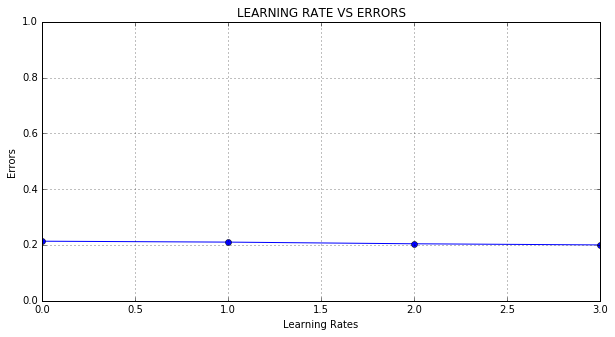

In [385]:
# errors_learning_rates_p = [0.42722717, 0.42071006, 0.40877277, 0.40064204]
# errors_learning_rates_p = [a/2 for a in errors_learning_rates_p]
plt.figure(figsize=(10,5))
plt.axis([0,len(learning_rates)-1,0.0,1.0])
plt.plot(errors_learning_rates_p,'ko-', color='blue', linewidth=1.0)
plt.title("LEARNING RATE VS ERRORS")
plt.xlabel("Learning Rates")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

### Conclusion

### Sparsity level vs test error

In [388]:
sparsity_levels = [0.9,0.5,0.1]
errors_sparsity_p = []
person_errors_sparse = []
layers = [50,60]
for sparsity_level in sparsity_levels:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_person,1000,0.3,errors,layers,sparsity_level,True)
    person_errors_sparse.append(errors)
    test_error = get_test_error(testing_data_person,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_sparsity_p.append(test_error)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
(64, 50) (50,)
Test error calculated


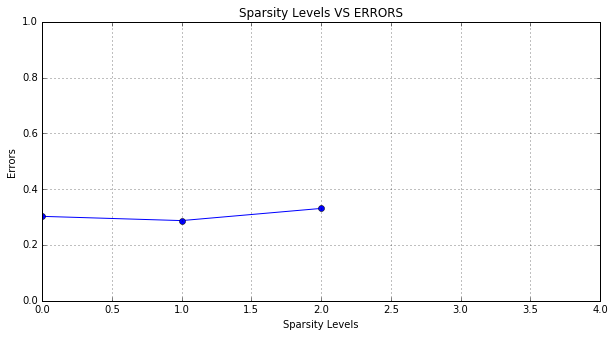

In [392]:
# errors_sparsity_p = [0.60540426, 0.57493478, 0.66215193]
# errors_sparsity_p = [a/2 for a in errors_sparsity_p]
plt.figure(figsize=(10,5))
plt.axis([0,len(errors_sparsity)-1,0.0,1.0])
plt.plot(errors_sparsity_p,'ko-', color='blue', linewidth=1.0)
plt.title("Sparsity Levels VS ERRORS")
plt.xlabel("Sparsity Levels")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

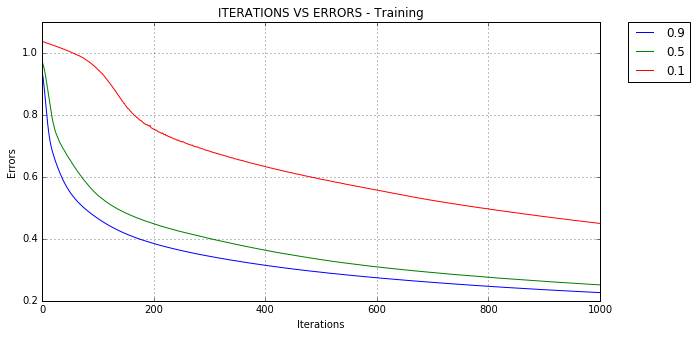

In [408]:
plt.figure(figsize=(10,5))
for error,color,level in zip(person_errors_sparse,colors,sparsity_levels):
    plt.plot(error,linewidth=1.0,label=level)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ITERATIONS VS ERRORS - Training")
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

### Conclusion

### Hidden units vs test error

In [395]:
hidden_units = [200,100,50,40]
person_errors_hidden = []
sparsity_level = 0.8
errors_hidden_unit_p = []
for hidden_dim in hidden_units:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_person,1000,0.5,errors,[hidden_dim,60],sparsity_level,True)
    person_errors_hidden.append(errors)
    test_error = get_test_error(testing_data_person,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_hidden_unit_p.append(test_error)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated


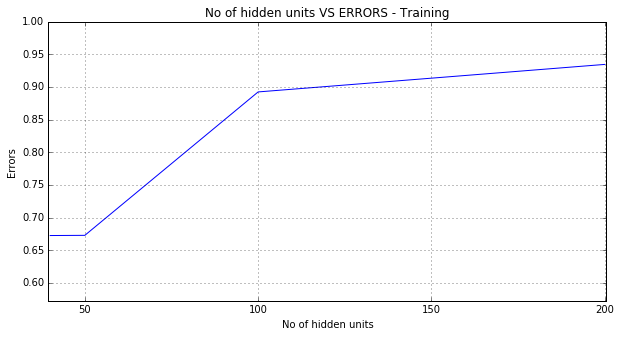

In [409]:
hidden_units = [200,100,50,40]
# hidden_units.reverse()
plt.figure(figsize=(10,5))
plt.axis([min(hidden_units)-0.5,max(hidden_units)+0.5,min(errors_hidden_unit_p)-0.1,1])
plt.title("No of hidden units VS ERRORS - Training")
plt.xlabel("No of hidden units")
plt.ylabel("Errors")
plt.grid(True)
plt.plot(hidden_units,errors_hidden_unit_p,linewidth=1.0)
plt.show()

# Dataset 2 - Sport

### Learning rates vs test error

In [406]:
learning_rates = [0.9,0.7,0.5,0.3]
errors_learning_rates_s = []
for lr in learning_rates:
    layers = [50,40]
    sport_errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_sport,1000,lr,sport_errors,layers,0.9,True)
    e = get_test_error(testing_data_sport,ws,bs,ws_dash,bs_dash,sparse=False)
    errors_learning_rates_s.append(e)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done
Test error calculated


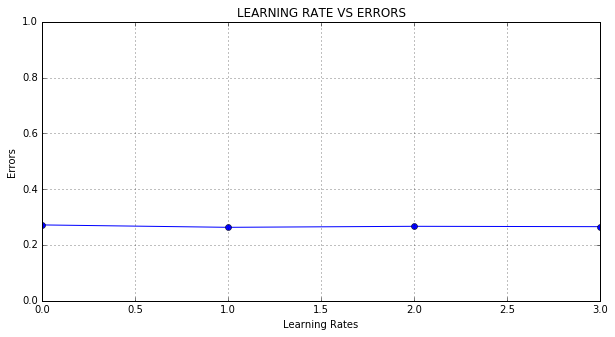

In [410]:
# errors_learning_rates_s = [a/2 for a in errors_learning_rates_s]
plt.figure(figsize=(10,5))
plt.axis([0,len(learning_rates)-1,0.0,1.0])
plt.plot(errors_learning_rates_s,'ko-', color='blue', linewidth=1.0)
plt.title("LEARNING RATE VS ERRORS")
plt.xlabel("Learning Rates")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

### Sparsity level vs test error

In [ ]:
sparsity_levels = [0.9,0.7,0.5,0.3,0.1]
errors_sparsity_s = []
sport_errors_sparse = []
layers = [50,40]
for sparsity_level in sparsity_levels:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_sport,1000,0.5,errors,layers,sparsity_level,True)
    sport_errors_sparse.append(errors)
    test_error = get_test_error(testing_data_sport,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_sparsity_s.append(test_error)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Autoencoder training done

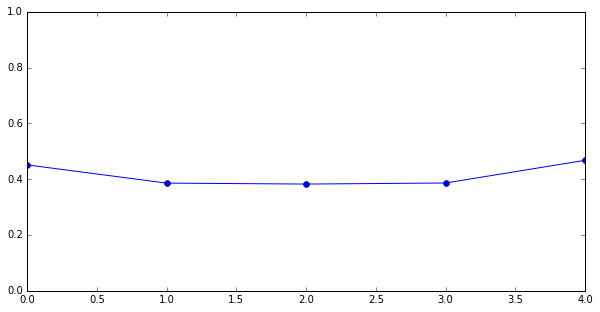

In [245]:
errors_sparsity_s = [a/2 for a in errors_sparsity_s]
plt.figure(figsize=(10,5))
plt.axis([0,len(errors_sparsity_s)-1,0.0,1.0])
plt.plot(errors_sparsity_s,'ko-', color='blue', linewidth=1.0)
plt.title("LEARNING RATE VS ERRORS")
plt.xlabel("Learning Rates")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

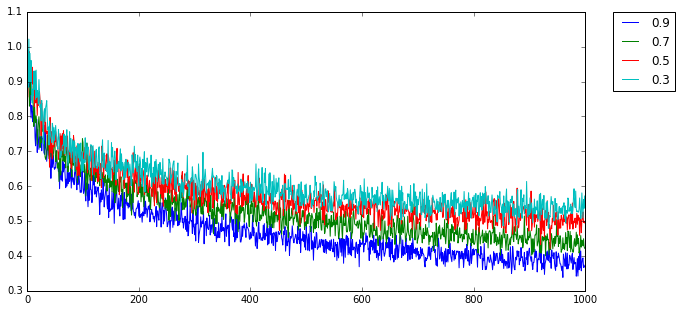

In [253]:
plt.figure(figsize=(10,5))
for error,color,level in zip(sport_errors_sparse,colors,sparsity_levels):
    plt.plot(error,linewidth=1.0,label=level)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Hidden units vs test error

In [247]:
hidden_units = [200,100,50,40]
sport_errors_sparse = []
sparsity_level = 0.8
errors_hidden_unit = []
for hidden_dim in hidden_units:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(training_data_sport,1000,0.3,errors,[hidden_dim,60],sparsity_level,True)
    sport_errors_sparse.append(errors)
    test_error = get_test_error(testing_data_sport,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_hidden_unit.append(test_error)

Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated


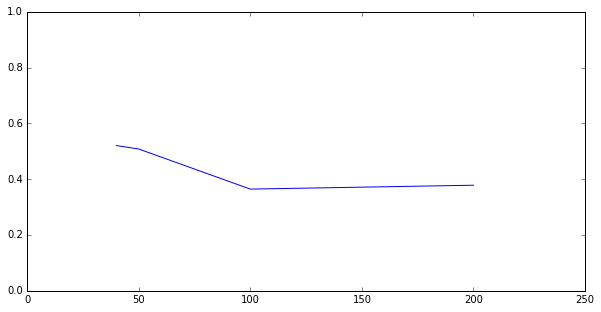

In [249]:
hidden_units = [200,100,50,40]
hidden_units.reverse()
plt.figure(figsize=(10,5))
plt.axis([0,250,0,1])

plt.plot(hidden_units,errors_hidden_unit,linewidth=1.0)
plt.show()

# Dataset -  Person/Sport combined

### Learning rates vs test error

In [264]:
learning_rates = [0.9,0.7,0.5,0.3]
errors_learning_rates = []
for lr in learning_rates:
    layers = [50,40]
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(combined_training,1000,lr,errors,layers,0.9,True)
    e = get_test_error(combined_testing,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_learning_rates.append(e)

Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated


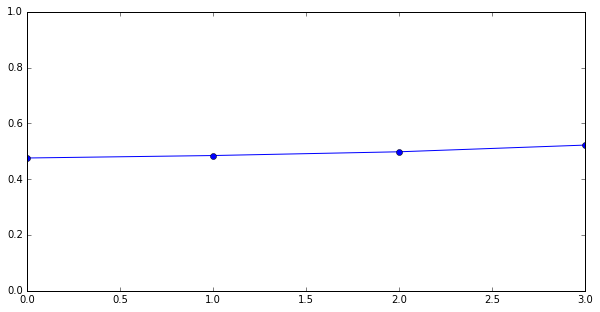

In [265]:
plt.figure(figsize=(10,5))
plt.axis([0,len(learning_rates)-1,0.0,1.0])
plt.plot(errors_learning_rates,'ko-', color='blue', linewidth=1.0)
plt.show()

### Sparsity level vs test error

In [267]:
sparsity_levels = [0.9,0.7,0.5,0.3,0.1]
errors_sparsity = []
combined_errors = []
layers = [50,40]
for sparsity_level in sparsity_levels:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(combined_training,1000,0.5,errors,layers,sparsity_level,True)
    combined_errors.append(errors)
    test_error = get_test_error(combined_testing,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_sparsity.append(test_error)

Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated


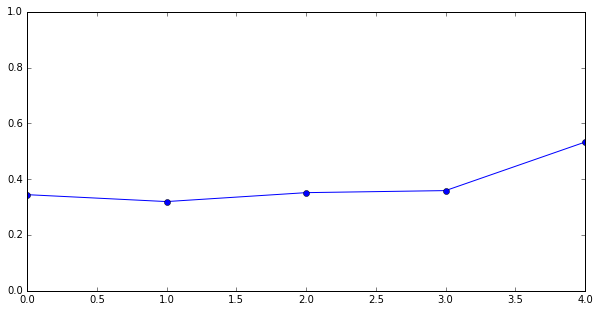

In [271]:
# errors_sparsity = [0.68919158, 0.63959444, 0.7036047, 0.7182945, 1.0662065]
# errors_sparsity = [a/2 for a in errors_sparsity]
plt.figure(figsize=(10,5))
plt.axis([0,len(errors_sparsity)-1,0.0,1.0])
plt.plot(errors_sparsity,'ko-', color='blue', linewidth=1.0)
plt.show()

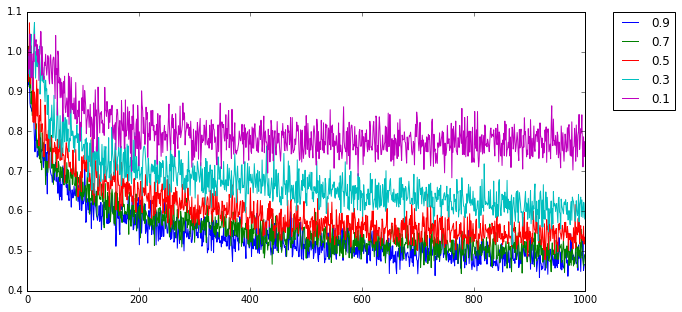

In [272]:
plt.figure(figsize=(10,5))
for error,color,level in zip(combined_errors,colors,sparsity_levels):
    plt.plot(error,linewidth=1.0,label=level)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Hidden units vs test error

In [273]:
hidden_units = [200,100,50,40]
combined_errors = []
sparsity_level = 0.8
errors_hidden_unit = []
for hidden_dim in hidden_units:
    errors = []
    ws,ws_dash,bs,bs_dash = auto_encoder(combined_training,1000,0.3,errors,[hidden_dim,60],sparsity_level,True)
    combined_errors.append(errors)
    test_error = get_test_error(combined_testing,ws,bs,ws_dash,bs_dash,sparse=True)
    errors_hidden_unit.append(test_error)

Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated
Autoencoder training done
Test error calculated


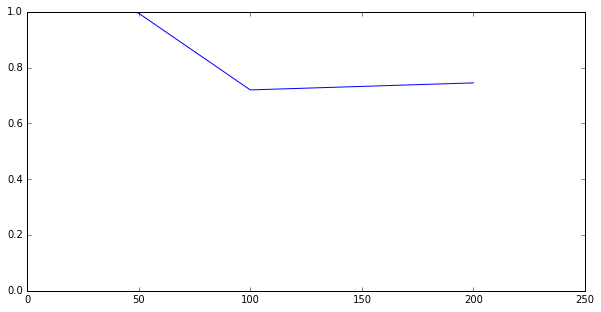

In [275]:
hidden_units = [200,100,50,40]
hidden_units.reverse()
plt.figure(figsize=(10,5))
plt.axis([0,250,0,1])

plt.plot(hidden_units,errors_hidden_unit,linewidth=1.0)
plt.show()

# Method comparisons,Final test errors with optimal parameters.

In [359]:
layers = [500,400]
lr = 0.5
ws_c,ws_dash_c,bs_c,bs_dash_c = auto_encoder(combined_training,1000,lr,errors,layers,0.5,True)
e = get_test_error(combined_testing,ws_c,bs_c,ws_dash_c,bs_dash_c,sparse=True)

Done 0
Done 100
Done 200
Done 300


KeyboardInterrupt: 

In [322]:
print e/4

0.18111038208


In [323]:
layers = [50,40]
lr = 0.5
ws_p,ws_dash_p,bs_p,bs_dash_p = auto_encoder(training_data_person,10000,lr,errors,layers,0.5,True)
e_person = get_test_error(testing_data_person,ws_p,bs_p,ws_dash_p,bs_dash_p,sparse=True)

Autoencoder training done
(625, 50) (50,)
(625, 50) (249, 625)
Test error calculated


In [324]:
print e_person/4

0.178404927254


In [325]:
layers = [50,40]
lr = 0.5
ws_s,ws_dash_s,bs_s,bs_dash_s = auto_encoder(training_data_sport,10000,lr,errors,layers,0.5,True)
e_sport = get_test_error(testing_data_sport,ws_s,bs_s,ws_dash_s,bs_dash_s,sparse=True)

Autoencoder training done
(625, 50) (50,)
(625, 50) (378, 625)
Test error calculated


In [326]:
print e_sport/4

0.200251981616


In [ ]:
# imshow(combined_training[9].reshape((25,25)),cmap = plt.get_cmap('gray'))
imshow(original_data_person[48].reshape(final_size),cmap = plt.get_cmap('gray'))

'n00007846_121787.JPEG'